# Assigment 1

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Find stationary equilibrium](#toc2_)    
- 3. [Vary tax rate](#toc3_)    
- 4. [Transition path](#toc4_)    
  - 4.1. [Prepare](#toc4_1_)    
  - 4.2. [Find transition path](#toc4_2_)    
  - 4.3. [Analyze](#toc4_3_)    
- 5. [Extra: Optimal policy](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCAssignmentModel import HANCModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Find stationary equilibrium](#toc0_)

Test household problem:

In [10]:
model.ss.w0 = 1.0
model.ss.w1 = 1.0
model.ss.rK = 0.01
model.ss.phi0 = 1.0
model.ss.phi1 = 2.0

#model.solve_hh_ss(do_print=True)
#model.simulate_hh_ss(do_print=True)

In [11]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.1 secs [71 iterations]


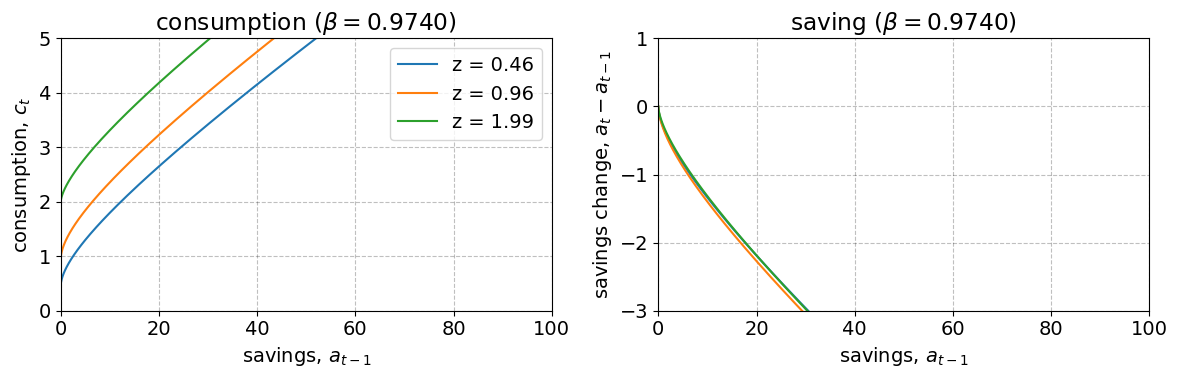

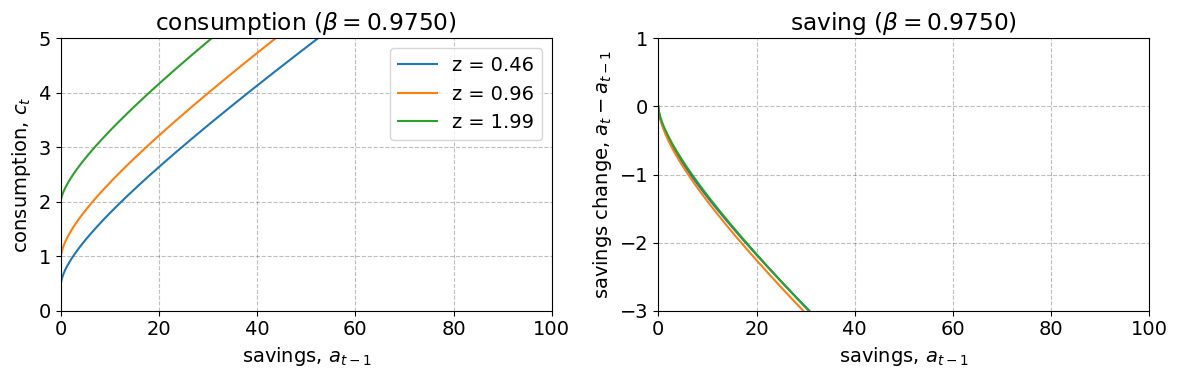

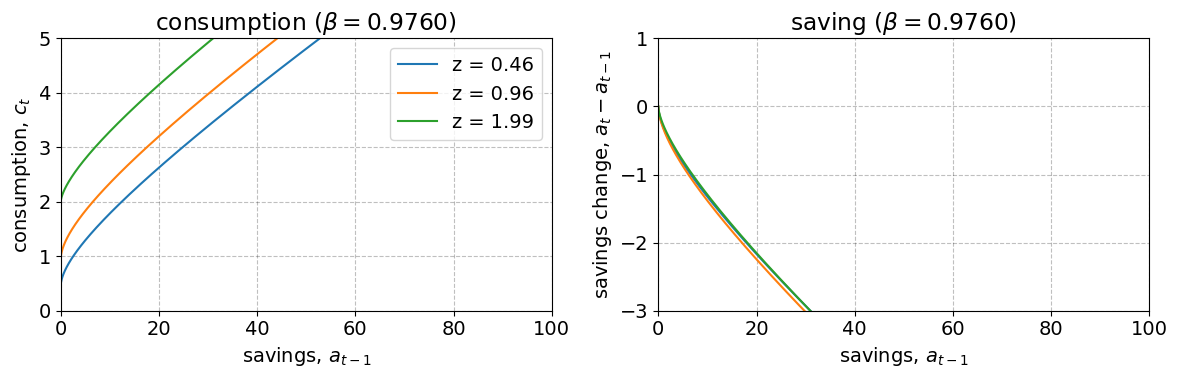

In [13]:
for i_beta,beta in enumerate(par.beta_grid[:len(par.beta_grid)//2]):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,5)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()
    #fig.savefig(f'figs/c_func_{i_beta}.pdf')

Find stationary equilibrium:

In [ ]:
model.find_ss(tau=0.15,do_print=True)

## 3. <a id='toc3_'></a>[Vary tax rate](#toc0_)

Choose to maximize average utility.

In [ ]:
def target(tau):
    
    model.find_ss(tau)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.11,0.2),method='bounded',options={'disp':3})
tau_max_U_hh = res.x
max_U_hh = res.fun

Look at different tax rates.

In [ ]:
taus = sorted([0.11,0.12,0.13,0.14,0.15]+[tau_max_U_hh])
B = np.zeros(len(taus))
pB = np.zeros(len(taus))
U_hh = np.zeros(len(taus))

for i,tau in enumerate(taus):
    
    model_ = model.copy()
    model_.find_ss(tau=tau,do_print=False)
    
    print(f'{model_.ss.pB = :8.3f}')
    print(f'{model_.ss.B = :8.3f}')
    print(f'{model_.ss.U_hh = :12.8f}\n')
    
    B[i] = model_.ss.B
    pB[i] = model_.ss.pB
    U_hh[i] = model_.ss.U_hh
    

In [ ]:
fig = plt.figure(figsize=(18,6/1.5),dpi=100)

ax = fig.add_subplot(1,3,1)
ax.set_title('bonds')
ax.axvline(tau_max_U_hh,color='black')
ax.plot(taus,B,'-o')
ax.set_xlabel('$\\tau_{ss}$')

ax = fig.add_subplot(1,3,2)
ax.set_title('bond price')
ax.axvline(tau_max_U_hh,color='black')
ax.plot(taus,pB,'-o')
ax.set_xlabel('$\\tau_{ss}$')

ax = fig.add_subplot(1,3,3)
ax.set_title('average  utility in ss')
ax.axvline(tau_max_U_hh,color='black')
ax.axhline(-max_U_hh,color='black')
ax.plot(taus,U_hh,'-o')
ax.set_xlabel('$\\tau_{ss}$')

fig.tight_layout()

**Insights:**

1. Bonds increasing in tax rate
2. Bond price decreasing in tax rate (higher return)
3. Average utility is hump-shaped (benefit from bonds providing liquidity)

**Note:** We can convert from *average utility* in steady state to *average value* (expected discounted utility) by:

In [ ]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
print(f'{V_hh_ss:.4f}')

A *utilitarian social planner* would maximize *social welfare*, which can e.g. be average value.

## 4. <a id='toc4_'></a>[Transition path](#toc0_)

In [ ]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

### 4.1. <a id='toc4_1_'></a>[Prepare](#toc0_)

In [ ]:
model.find_ss(tau=tau_max_U_hh)

In [ ]:
model.test_hh_path()

In [ ]:
model.test_path()

**Jacobians:**

In [ ]:
model.compute_jacs()

**Higher bond price:** Always less savings due to lower return.

**Higher tax rate:**

1. Lower savings when in effect due to lower income
2. Higher savings when expected due to lower *future* income

In [ ]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

### 4.2. <a id='toc4_2_'></a>[Find transition path](#toc0_)

In [ ]:
jump = ss.G*0.01
rho = 0.95
dG = jump*rho**np.arange(par.T)

In [ ]:
model.find_transition_path(shocks={'dG':dG},do_print=True) #important you can only call a variable defined as shock already
path = model.path

### 4.3. <a id='toc4_3_'></a>[Analyze](#toc0_)

The government issues more bonds. Bond price fall and tax increases. Average utility falls.

In [ ]:
model.show_IRFs(varnames=['B','pB','tau','U_hh'],lvl_value=['U_hh'],ncols=2)

Expected discounted utility falls.

In [ ]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
V_hh = np.sum([par.beta**t*path.U_hh[t] for t in range(par.T)])
print(f'{V_hh_ss = :.5f}')
print(f'{V_hh = :.5f}')

Initially savings increase both due to taxes (less future income) and higher return (lower bond price). Lower taxes reduce savings.

In [ ]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['tau'],['pB'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

Consumption inequality decreases. But small effect relative to the lower mean.

In [ ]:
mean_c_ss = np.sum(ss.D*ss.c)
std_c_ss = np.sqrt(np.sum(ss.D*(ss.c-mean_c_ss)**2))   

for t in range(20):

    mean_c = np.sum(path.D[t]*path.c[t])
    std_c = np.sqrt(np.sum(path.D[t]*(path.c[t]-mean_c)**2))   

    print(f't = {t:2d}: {mean_c-mean_c_ss:7.4f}, {std_c-std_c_ss:7.4f}')

## 5. <a id='toc5_'></a>[Extra: Optimal policy](#toc0_)

**Questions:** Will a utiliarian planner always set the tax rate so it maximizes steady state social welfare?

In [ ]:
for add in [-0.01,0.01]:

    # a. initial steady state
    model_tau_alt = model.copy()
    model_tau_alt.find_ss(tau=tau_max_U_hh+add)

    # b. transition to new steady state 
    model.find_transition_path(shocks=[],ini=model_tau_alt.ss.__dict__,do_print=False)
    path = model.path

    # b. change in expected discounted utility
    V_hh_ss = np.sum([par.beta**t*model_tau_alt.ss.U_hh for t in range(par.T)])
    V_hh = np.sum([par.beta**t*path.U_hh[t] for t in range(par.T)])
    print(f'tau {tau_max_U_hh+add:.3} -> {tau_max_U_hh:.3f}: {V_hh-V_hh_ss = :8.5f}')


If the initial tax rate is low, the transition is beneficial. Social welfare increases.

If the initial tax rate is high, the transition is not beneficial. Social welfare increase.

**Insight:** Optimal policy needs to account for the transition.

**Questions:** Could there ne another transition, which makes the policy beneficial?
